# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [6]:
import os
os.chdir(r"D:\DL\TD_data_science\MACS3_Stats_TDs")

In [7]:
!pip install openpyxl

In [8]:
import pandas as pd

path_data = r"D:\DL\TD_data_science\MACS3_Stats_TDs\data\accars_b.xlsx"
data = pd.read_excel(path_data)

In [9]:
data.head()



,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
0,CLIMB,186,10,192,1,Neutral,1.0,151.0,6.0,-0.1146,...,88.0,0.57,0.73,0.12,0.13,8.9,5.0,5.0,5335.0,0.637
1,CLIMB,186,10,192,1,Neutral,1.0,143.0,7.0,-0.2464,...,90.8,0.58,0.76,0.15,0.10,9.0,5.6,5.6,4987.0,0.624
2,CLIMB,186,10,192,1,Neutral,1.0,163.0,8.0,NaN,...,89.0,0.28,0.48,0.16,0.05,10.1,5.0,5.2,4251.0,0.530
3,CLIMB,186,10,192,1,Neutral,1.0,152.0,9.0,NaN,...,87.0,0.44,0.67,0.14,0.08,8.9,5.6,5.6,5356.0,0.380
4,CLIMB,186,10,192,1,Neutral,1.0,154.0,10.0,NaN,...,85.3,0.26,0.48,0.25,0.06,10.5,5.6,5.6,NaN,0.543


#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

Text(0.5, 1.0, 'répartition des valeurs manquantes')

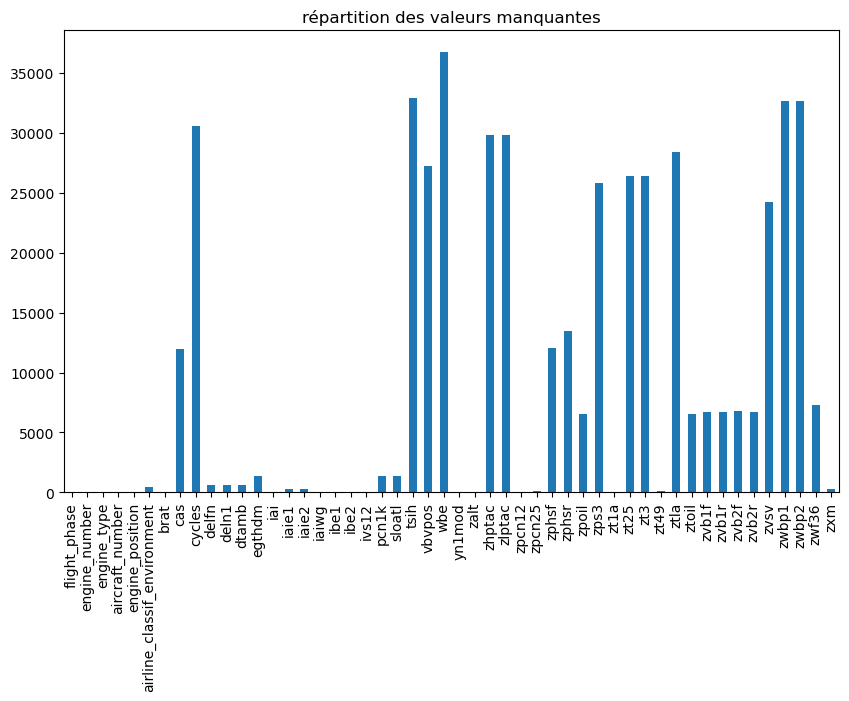

In [10]:
import matplotlib.pyplot as plt

missing_values = data.isnull().sum()
missing_values

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title("répartition des valeurs manquantes")

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [11]:
data_2 = data.dropna(subset=['cycles','egthdm'])
missing_values_2 = data_2.isnull().sum()

print(data_2.shape)
data.shape

(15374, 50)


(46621, 50)

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [12]:
print(data_2["engine_type"].unique())

[10  5  7]


In [42]:
data_2.head()

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
104,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,5.0,23.8191,...,84.3,0.39,0.58,0.05,0.15,12.3,0.2,0.0,NaN,0.133
105,TAKEOFF,186,10,192,1,Neutral,0.0,93.0,6.0,25.4038,...,95.1,0.24,0.69,0.16,0.10,11.1,0.2,0.0,NaN,0.148
106,TAKEOFF,186,10,192,1,Neutral,0.0,92.0,7.0,22.7509,...,81.6,0.23,0.46,0.13,0.11,12.1,0.3,0.0,NaN,0.140
107,TAKEOFF,186,10,192,1,Neutral,0.0,87.0,8.0,22.1533,...,87.8,0.59,0.80,0.12,0.13,11.1,0.2,0.0,NaN,0.140
108,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,9.0,23.8673,...,79.3,0.43,0.47,0.13,0.17,12.5,0.3,0.0,NaN,0.136


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [13]:
data_moteur_10 = data_2[data_2['engine_type'] == 10]
nb_avions_distincts = data_moteur_10['aircraft_number'].nunique()

avions_distincts = data_moteur_10['aircraft_number'].unique()

takeoff_data = data_moteur_10[data_moteur_10['flight_phase'] == 'TAKEOFF']
nbre_avions_takeoff = takeoff_data.groupby('aircraft_number').size()/2

nbre_avions_takeoff

aircraft_number
11      17.0
14      97.0
190    110.0
191      6.0
192    126.0
dtype: float64

## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [14]:
avion_190 = data_moteur_10[data_moteur_10['aircraft_number'] == 190]

avion_190_df = avion_190[['engine_number', 'cycles', 'egthdm']].sort_values(by='cycles',ascending=True)
avion_190_df

,engine_number,cycles,egthdm
11755,179,0.0,37.6572
11780,180,0.0,46.3442
11781,180,1.0,43.2150
11756,179,1.0,37.2208
30796,179,1.0,59.1796
...,...,...,...
40125,180,109.0,53.0332
26854,180,114.0,55.4859
29636,179,114.0,49.2813
41591,180,163.0,48.3014


In [15]:
data_moteur_10.head()

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
104,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,5.0,23.8191,...,84.3,0.39,0.58,0.05,0.15,12.3,0.2,0.0,NaN,0.133
105,TAKEOFF,186,10,192,1,Neutral,0.0,93.0,6.0,25.4038,...,95.1,0.24,0.69,0.16,0.10,11.1,0.2,0.0,NaN,0.148
106,TAKEOFF,186,10,192,1,Neutral,0.0,92.0,7.0,22.7509,...,81.6,0.23,0.46,0.13,0.11,12.1,0.3,0.0,NaN,0.140
107,TAKEOFF,186,10,192,1,Neutral,0.0,87.0,8.0,22.1533,...,87.8,0.59,0.80,0.12,0.13,11.1,0.2,0.0,NaN,0.140
108,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,9.0,23.8673,...,79.3,0.43,0.47,0.13,0.17,12.5,0.3,0.0,NaN,0.136


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

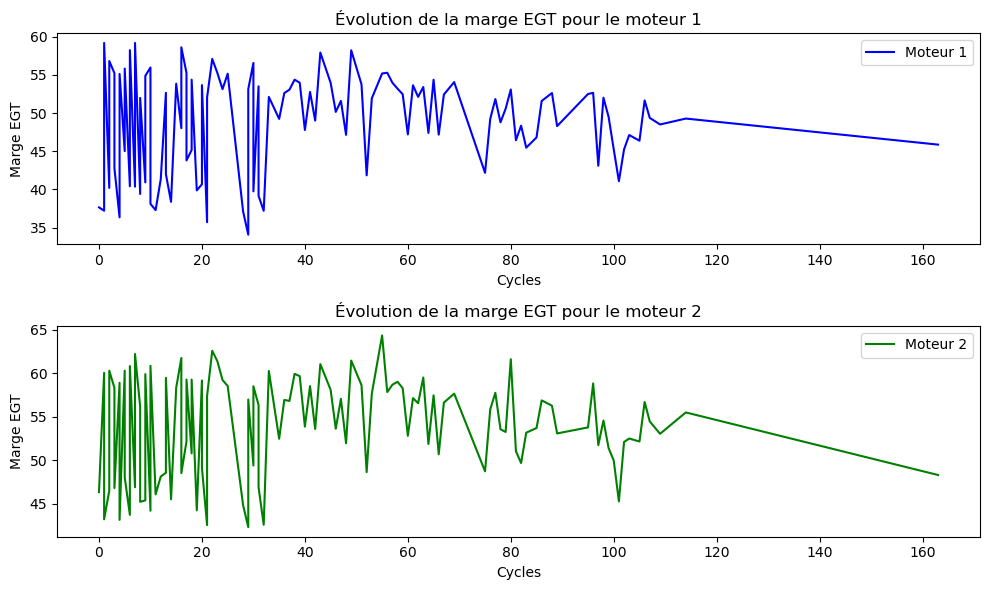

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
11755,TAKEOFF,179,10,190,1,Neutral,0.0,89.0,0.0,23.8403,...,82.5,0.09,0.20,0.23,0.42,12.2,0.2,0.2,NaN,0.137
11756,TAKEOFF,179,10,190,1,Neutral,0.0,85.0,1.0,24.2280,...,84.5,0.15,0.15,0.15,0.16,12.5,0.2,0.0,NaN,0.128
30796,TAKEOFF,179,10,190,1,Neutral,0.0,87.0,1.0,18.5592,...,91.3,0.34,0.72,0.26,0.16,11.5,0.0,0.0,NaN,0.136
11757,TAKEOFF,179,10,190,1,Neutral,0.0,86.0,2.0,23.6616,...,92.6,0.14,0.24,0.18,0.20,12.5,0.2,0.0,NaN,0.132
25359,TAKEOFF,179,10,190,1,Neutral,0.0,89.0,2.0,20.7576,...,100.0,0.21,0.62,0.36,0.07,12.0,0.0,0.0,NaN,0.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28386,TAKEOFF,179,10,190,1,Neutral,0.0,87.0,106.0,23.8891,...,90.8,0.23,0.37,0.29,0.22,12.6,0.0,0.0,NaN,0.132
36515,TAKEOFF,179,10,190,1,Neutral,0.0,90.0,107.0,22.5002,...,84.3,0.06,0.37,0.32,0.26,12.3,0.0,0.0,NaN,0.137
42808,TAKEOFF,179,10,190,1,Neutral,0.0,89.0,109.0,22.6066,...,95.9,0.13,0.30,0.10,0.11,12.3,0.0,0.0,NaN,0.135
29636,TAKEOFF,179,10,190,1,Neutral,0.0,88.0,114.0,23.9556,...,93.0,0.11,0.23,0.03,0.15,12.7,0.0,0.0,NaN,0.136


In [16]:
moteur_1 = avion_190[avion_190['engine_number'] == 179].sort_values(by='cycles',ascending=True)
moteur_2 = avion_190[avion_190['engine_number'] == 180].sort_values(by='cycles',ascending=True)



plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(moteur_1['cycles'], moteur_1['egthdm'], label='Moteur 1', color='blue')
plt.title('Évolution de la marge EGT pour le moteur 1')
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(moteur_2['cycles'], moteur_2['egthdm'], label='Moteur 2', color='green')
plt.title('Évolution de la marge EGT pour le moteur 2')
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()

plt.tight_layout()
plt.show()

moteur_1

#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [17]:

cycles_present = moteur_1['cycles']



cycle_min = int(cycles_present.min())
cycle_max = int(cycles_present.max())


tous_cycles = set(range(cycle_min, cycle_max + 1))
cycles_manquants = tous_cycles - set(cycles_present)

len(cycles_manquants)


73

#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [18]:
egt = moteur_1.groupby('cycles')['egthdm'].max()
print(egt)
type(egt)
egt = egt.reset_index(name='max_egthdm')
egt = egt.set_index('cycles').reindex(tous_cycles)
egt


cycles
0.0      37.6572
1.0      59.1796
2.0      56.8104
3.0      55.2263
4.0      55.1283
          ...   
106.0    51.6519
107.0    49.3682
109.0    48.5079
114.0    49.2813
163.0    45.8711
Name: egthdm, Length: 91, dtype: float64


,max_egthdm
cycles,
0,37.6572
1,59.1796
2,56.8104
3,55.2263
4,55.1283
...,...
159,NaN
160,NaN
161,NaN


#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

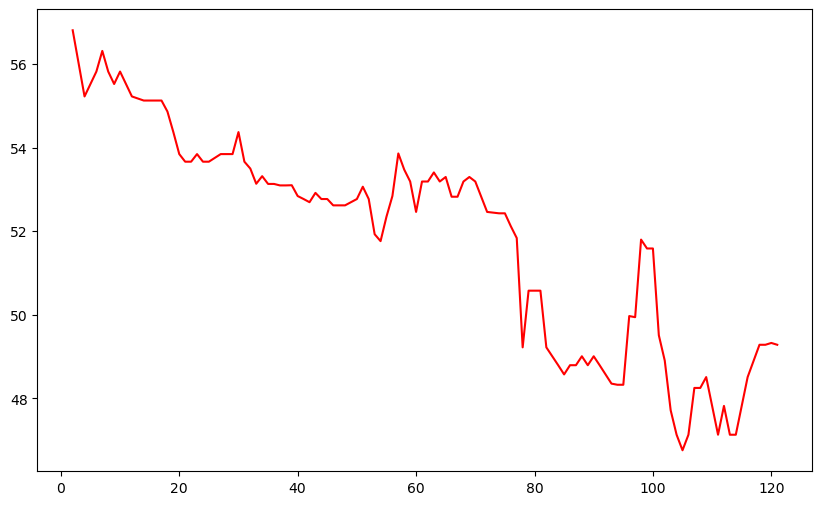

In [19]:
egt['max_egthdm_lisse'] = egt['max_egthdm'].rolling(window=15, min_periods=3).median()


plt.figure(figsize=(10, 6))

plt.plot(egt.index, egt['max_egthdm_lisse'], label='Marge EGT lissée', color='red')





#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

        max_egthdm_lisse  max_egthdm_pessimiste
cycles                                         
0                    NaN                    NaN
1                    NaN                    NaN
2               56.81040               56.81040
3               56.01835               56.01835
4               55.22630               55.22630
...                  ...                    ...
159                  NaN                    NaN
160                  NaN                    NaN
161                  NaN                    NaN
162                  NaN                    NaN
163                  NaN                    NaN

[164 rows x 2 columns]


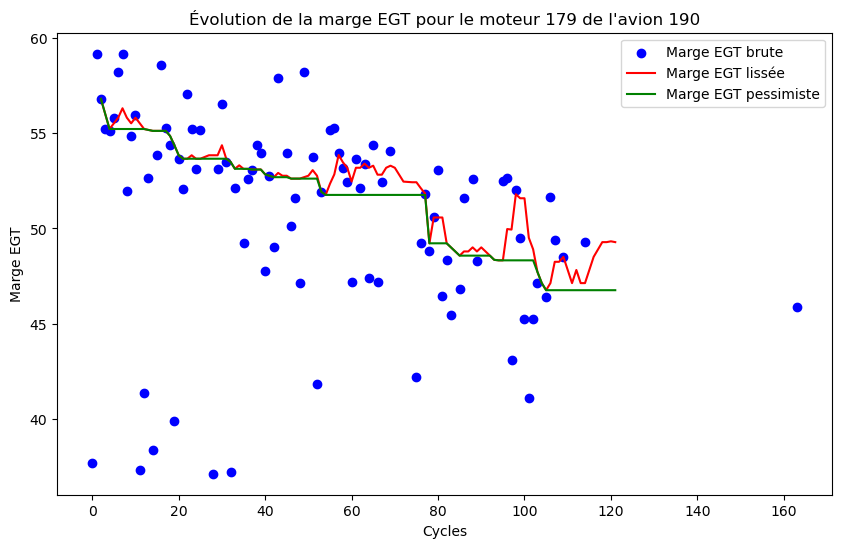

In [24]:
# Calcul du minimum cumulatif pour obtenir une série décroissante
egt['max_egthdm_pessimiste'] = egt['max_egthdm_lisse'].cummin()

print(egt[['max_egthdm_lisse', 'max_egthdm_pessimiste']])



plt.figure(figsize=(10, 6))


plt.scatter(egt.index, egt['max_egthdm'], label='Marge EGT brute', color='blue')


plt.plot(egt.index, egt['max_egthdm_lisse'], label='Marge EGT lissée', color='red')

plt.plot(egt.index, egt['max_egthdm_pessimiste'], label='Marge EGT pessimiste', color='green')

plt.title("Évolution de la marge EGT pour le moteur 179 de l'avion 190")
plt.xlabel('Cycles')
plt.ylabel('Marge EGT')
plt.legend()
plt.show()


#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [25]:
from sklearn.linear_model import LinearRegression

# Suppression des valeurs NaN pour la régression
egt_pessimiste = egt.dropna(subset=['max_egthdm_pessimiste'])

X = egt_pessimiste.index.values.reshape(-1, 1)  # Nombre de cycles
y = egt_pessimiste['max_egthdm_pessimiste'].values  # Marge EGT pessimiste

lr = LinearRegression()
model = lr.fit(X, y)

print(f"Pente (coefficient) : {model.coef_[0]:.6f}")
print(f"Ordonnée à l'origine (intercept) : {model.intercept_:.6f}")


Pente (coefficient) : -0.080520
Ordonnée à l'origine (intercept) : 56.190662


### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

In [50]:
def regress_egt_margin(df_acars):
    df_filtered = df_acars[(df_acars['flight_phase'] == 'TAKEOFF')]
    results = []
    moteurs = df_filtered['engine_number'].unique()
    
    for moteur in moteurs:
        moteur_data = df_filtered[df_filtered['engine_number'] == moteur]
        moteur_data = moteur_data[['cycles', 'egthdm']].dropna().sort_values(by='cycles')
        
        if moteur_data.empty:
            continue

        egt = moteur_data.groupby('cycles')['egthdm'].max()
        cycle_min = int(egt.index.min())
        cycle_max = int(egt.index.max())
        tous_cycles = set(range(cycle_min, cycle_max + 1))
        egt = egt.reindex(tous_cycles)
        egt_lisse = egt.rolling(window=15, min_periods=3).median()
        egt_pessimiste = egt_lisse.cummin().dropna()

        if egt_pessimiste.empty:
            continue

        X = egt_pessimiste.index.values.reshape(-1, 1)
        y = egt_pessimiste.values  
        lr = LinearRegression()
        model = lr.fit(X, y)
        results.append({
            'engine_number': moteur,
            'slope': model.coef_[0],
            'intercept': model.intercept_
        })
    
    return pd.DataFrame(results)

Prédictions des marges EGT au 150ème cycle pour chaque moteur :
     engine_number     egt_150
0              186   54.842011
1              187   57.567535
2              184   45.512458
3              188   59.227585
4                1   92.058117
..             ...         ...
177             61   61.606351
178             25  110.965106
179             15  115.422000
180             81   85.431467
181             14  122.567918

[182 rows x 2 columns]


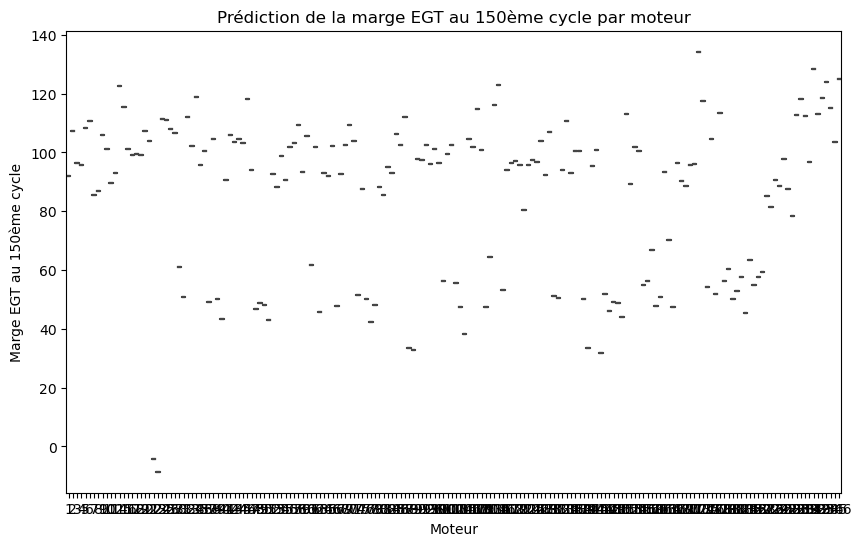

Moyenne des marges EGT au 150ème cycle par moteur :
engine_number
1       92.058117
2      107.199017
3       96.442726
4       95.694236
5      108.439538
          ...    
325    118.674469
328    123.812850
336    115.187702
345    103.579270
346    125.120355
Name: egt_150, Length: 182, dtype: float64
Le type de moteur avec la plus grande marge moyenne après 150 cycles est le moteur 173.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_regress_models = regress_egt_margin(data)
df_regress_models['egt_150'] = df_regress_models['intercept'] + df_regress_models['slope']

print("Prédictions des marges EGT au 150ème cycle pour chaque moteur :")
print(df_regress_models[['engine_number', 'egt_150']])

plt.figure(figsize=(10, 6))
sns.boxplot(x='engine_number', y='egt_150', data=df_regress_models)
plt.title('Prédiction de la marge EGT au 150ème cycle par moteur')
plt.xlabel('Moteur')
plt.ylabel('Marge EGT au 150ème cycle')
plt.show()


mean_egt_150 = df_regress_models.groupby('engine_number')['egt_150'].mean()

print("Moyenne des marges EGT au 150ème cycle par moteur :")
print(mean_egt_150)


max_mean_egt_motor = mean_egt_150.idxmax()
print(f"Le type de moteur avec la plus grande marge moyenne après 150 cycles est le moteur {max_mean_egt_motor}.")


### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

Index(['engine_number', 'slope', 'intercept', 'egt_pred_150', 'engine_type'], dtype='object')


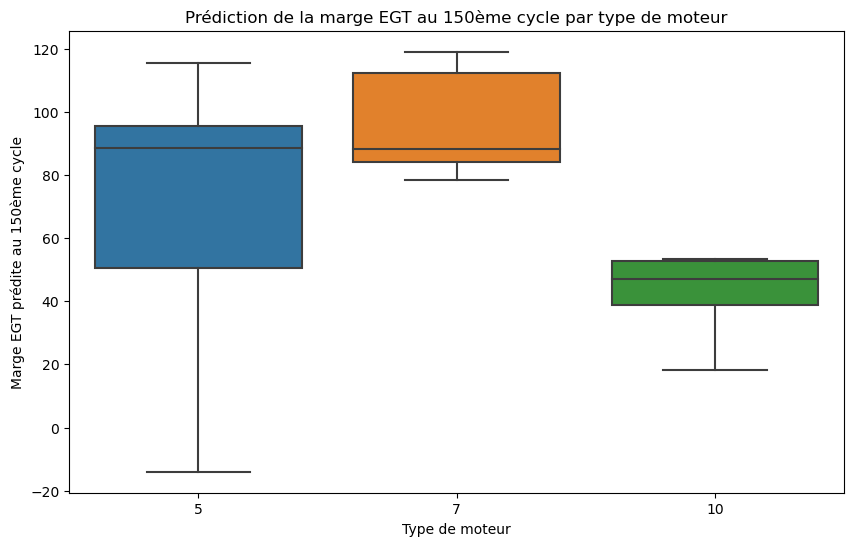

Marge moyenne prédite au 150ème cycle par type de moteur :
 engine_type
5     76.248486
7     95.666588
10    42.636241
Name: egt_pred_150, dtype: float64
Le type de moteur avec la plus grande marge moyenne après 150 cycles est le moteur 7.


In [55]:
df_regress_models = regress_egt_margin(data_2) # data_2 est filtrée

# Prédiction de la marge EGT après 150 cycles pour chaque moteur
df_regress_models['egt_pred_150'] = df_regress_models['intercept'] + df_regress_models['slope'] * 150


engine_types = data_2[['engine_number', 'engine_type']].drop_duplicates()
df_regress_models = df_regress_models.merge(engine_types, on='engine_number', how='left')


print(df_regress_models.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(x='engine_type', y='egt_pred_150', data=df_regress_models)
plt.title('Prédiction de la marge EGT au 150ème cycle par type de moteur')
plt.xlabel('Type de moteur')
plt.ylabel('Marge EGT prédite au 150ème cycle')
plt.show()

avg_margin_150 = df_regress_models.groupby('engine_type')['egt_pred_150'].mean()
print("Marge moyenne prédite au 150ème cycle par type de moteur :\n", avg_margin_150)


max_mean_egt_motor = avg_margin_150.idxmax()
print(f"Le type de moteur avec la plus grande marge moyenne après 150 cycles est le moteur {max_mean_egt_motor}.")


In [54]:
unique_engine_numbers = df_regress_models['engine_type'].unique()
print(unique_engine_numbers)


[10  5  7]


#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?

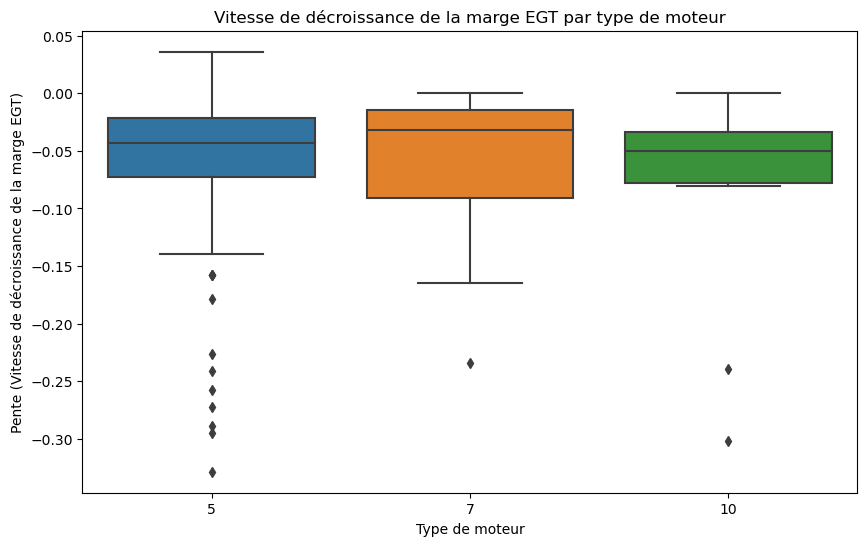

In [56]:
## 1. Unité : marge/cycle
## 2. 

plt.figure(figsize=(10, 6))
sns.boxplot(x='engine_type', y='slope', data=df_regress_models)
plt.title('Vitesse de décroissance de la marge EGT par type de moteur')
plt.xlabel('Type de moteur')
plt.ylabel('Pente (Vitesse de décroissance de la marge EGT)')
plt.show()

le boxplot indique que les moteurs de type 10 semblent avoir la plus faible vitesse de décroissance de la marge EGT, tandis que les moteurs de type 5 présentent une plus grande variabilité et des dégradations plus importantes.

In [57]:
## 3.

mean_slope = df_regress_models.groupby('engine_type')['slope'].mean().reset_index()
mean_slope.columns = ['engine_type', 'mean_slope']
print(mean_slope)


   engine_type  mean_slope
0            5   -0.057707
1            7   -0.057895
2           10   -0.088075


In [58]:
lowest_decay = mean_slope.loc[mean_slope['mean_slope'].idxmin()]
print(f'Type de moteur avec la plus faible vitesse de décroissance: {lowest_decay["engine_type"]}, Vitesse de décroissance: {lowest_decay["mean_slope"]}')


Type de moteur avec la plus faible vitesse de décroissance: 10.0, Vitesse de décroissance: -0.0880753313880936
